In [1]:
import sys; sys.path.append('/home/clair/wwa'); from wwa import *

# cproj = cartopy.crs.LambertConformal(central_longitude = -105, standard_parallels = [50,60])
# cproj = cartopy.crs.epsg(3347)
cproj = cartopy.crs.PlateCarree()

In [11]:
def transform_xy(x, y, crs_in = None, crs_out = None):
    
    # transform 1d or 2d coords into 2d coords in another projection
    
    x = np.array(x)
    y = np.array(y)
    
    if x.ndim == 1:
        # tile 1d coordinates into 2d arrays of x, y per cell
        x_2d = np.tile(np.array(x), (len(y), 1))
        y_2d = np.tile(np.array([y]).transpose(), (1, len(x)))
    else:
        # coordinates are already 2d arrays
        x_2d = x
        y_2d = y
    
    if crs_in is None or crs_out is None:
        # return tiled points on original grid
        return x_2d, y_2d
        
    else:
        # transform and return
        xy_transf = crs_out.transform_points(crs_in, x_2d, y_2d)
        return xy_transf[:,:,0], xy_transf[:,:,1]

---
## **Maps of event**

In [49]:
sf = gpd.read_file("sf_hfr").to_crs(cproj)
da = xr.open_dataset("data/percentile_99_map.nc").fwi
rm = regionmask.defined_regions.natural_earth_v5_0_0.countries_110.mask_3D(da.longitude, da.latitude).sel(region = 3).reset_coords(drop = True)

<GeoAxesSubplot: title={'center': '99th percentile of FWI during May-June 2023 (ERA5)'}, xlabel='longitude', ylabel='latitude'>

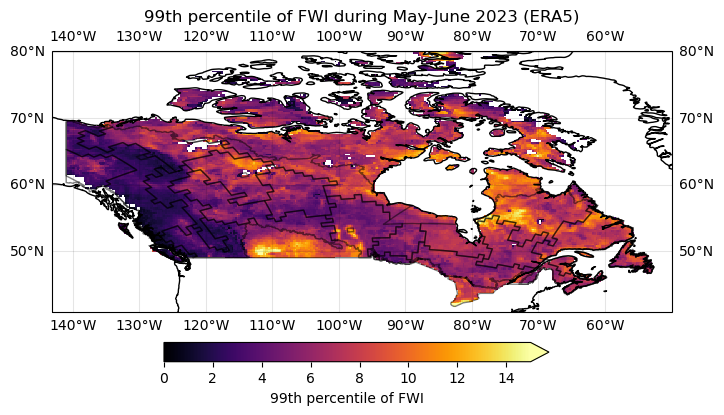

In [ ]:
fig, ax = plt.subplots(figsize = (8,5), dpi = 100, subplot_kw = {"projection" : cproj})

da.where(rm).plot(ax = ax, cmap = "inferno", cbar_kwargs = {"location" : "bottom", "fraction" : 0.05, "label" : "99th percentile of FWI", "pad" : 0.08}, vmin = 0, vmax = 15)
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, alpha = 0.5)
ax.gridlines(color = "k", alpha = 0.1, draw_labels = True, xlocs = range(-140,-50,10), ylocs = range(40,90,10))
ax.set_title("99th percentile of FWI during May-June 2023 (ERA5)")

sf.boundary.plot(ax = ax, lw = 1, color = "k", alpha = 0.5)

# [ax.annotate(text = v.NAMES_SHOR, xy = (v.geometry.representative_point().x, v.geometry.representative_point().y)) for k,v in sf.iterrows()]

# plt.savefig("fig/fwi99-map.png")

### **MODIS burned area data**

In [1]:
# sftp fire@fuoco.geog.umd.edu (password: burnt)

# get /data/MODIS/C61/MCD64A1/HDF/h11v04/MCD64A1.A2023*

# h = 10-14; v = 2-4; days 121 and 152

In [2]:
import rioxarray as rxr, xarray as xr
import glob, re
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy
import numpy as np

def transform_xy(x, y, crs_in = None, crs_out = None):
    
    # transform 1d or 2d coords into 2d coords in another projection
    
    x = np.array(x)
    y = np.array(y)
    
    if x.ndim == 1:
        # tile 1d coordinates into 2d arrays of x, y per cell
        x_2d = np.tile(np.array(x), (len(y), 1))
        y_2d = np.tile(np.array([y]).transpose(), (1, len(x)))
    else:
        # coordinates are already 2d arrays
        x_2d = x
        y_2d = y
    
    if crs_in is None or crs_out is None:
        # return tiled points on original grid
        return x_2d, y_2d
        
    else:
        # transform and return
        xy_transf = crs_out.transform_points(crs_in, x_2d, y_2d)
        return xy_transf[:,:,0], xy_transf[:,:,1]

sf = gpd.read_file("sf_hfr").to_crs(cartopy.crs.PlateCarree())

In [3]:
# d = "2022152"
# da = xr.concat([xr.concat([rxr.open_rasterio(glob.glob("modis/*"+d+".h"+h+"v"+v+"*.hdf")[0])
#                            for h in [str(h).rjust(2, "0") for h in range(10,15)]], "x")
#                 for v in [str(v).rjust(2, "0") for v in range(2,5)]], "y").squeeze(drop = True)
# lons, lats = transform_xy(da.x, da.y, crs_in = cartopy.crs.Sinusoidal(), crs_out = cartopy.crs.PlateCarree())
# da = da.assign_coords(lon = (["y", "x"], lons), lat = (["y", "x"], lats))
# da.to_netcdf("data/modis_"+d+".nc")

In [4]:
da = xr.open_dataset("data/modis_2022121.nc")

In [ ]:
da["Burn Date"].plot()

In [ ]:
da["Burn Date"].where(da["Burn Date"] >= 0).plot()

<GeoAxesSubplot: >

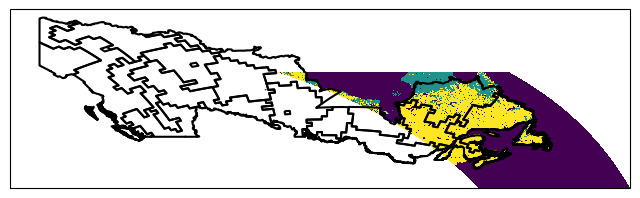

In [50]:
fig, ax = plt.subplots(ncols = 1, figsize = (8,5), subplot_kw = {"projection" : cartopy.crs.PlateCarree()})
ax.pcolormesh(lons, lats, da["Burn Date"].squeeze())
sf.boundary.plot(ax = ax, color = "k")

### **National fire database observed wildfires (-2021)**

In [12]:
df = pd.read_csv("data/NFDB_Canada_observed_wildfires_1959-2021.csv", sep = " ", index_col = 0)

In [18]:
df.loc[[y == 2021 for y in df.YEAR]]

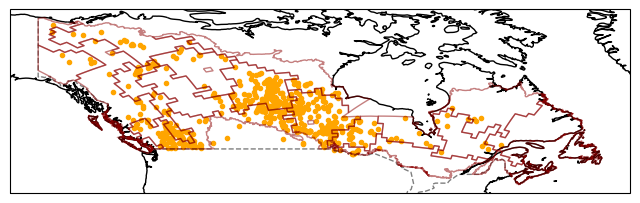

In [48]:
fig, ax = plt.subplots(figsize = (8,5), dpi = 100, subplot_kw = {"projection" : cproj})
ax.coastlines(color = "k")
ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.5, color = "k")
sf.boundary.plot(ax = ax, color = "darkred", lw = 1, alpha = 0.5)

ax.scatter(list(df.loc[[y == 2021 for y in df.YEAR], "LONGITUDE"]), list(df.loc[[y == 2021 for y in df.YEAR], "LATITUDE"]), marker = ".", color = "orange")